# Chapter IV: Improving Training of PINNs

This notebook covers techniques to improve the training of Physics-Informed Neural Networks (PINNs).

In [1]:
import sys
sys.path.append('examples/allen_cahn')
results_folder = 'results/IV_ImprovingTraining'

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots  # optional, requires latex
plt.style.use(['science', 'grid'])
import pickle
import copy

from allen_cahn_model import train_allen_cahn, test_data_allen_cahn, eval_allen_cahn, pde_allen_cahn, plot_allen_cahn_results

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.

Enable just-in-time compilation with XLA.



## IV_2: Fourier Feature Embedding

Fourier features help in learning high-frequency components.

### 1-Run/load model

In [18]:
config_to_run_FF = []#["pinn", "spinn", "spinn_mod"]
results_file = os.path.join(results_folder, 'IV_2_FourierFeatures.pkl')

base_config_FF = {
    "fourier_features": False,
    "n_fourier_features": 128,
    "sigma": 10,
    "net_type": "PINN",
    "mlp_type": "mlp",
    "activations": "sin",
    "n_domain": 150**2,
    "lr": 1e-5,
    "lr_decay": ["warmup cosine", 1e-3, 1000, 60000, 1e-5], # cosine decay: peak lr, warmup iters, total iters, min lr
    "n_iter": 80000, 
    "rank": 64,
    "seed": 0,
}

all_config_FF = {
    "pinn": {**copy.deepcopy(base_config_FF), "n_fourier_features": 256},
    "spinn": {**copy.deepcopy(base_config_FF), "net_type": "SPINN" },
    "spinn_mod": {**copy.deepcopy(base_config_FF), "net_type": "SPINN", "mlp_type": "mlp_mod" },
}

all_config_names_FF = list(all_config_FF.keys())

all_data_FF = {}
all_models_FF = {}
try:
    with open(results_file, 'rb') as f:
        saved_results = pickle.load(f)
except Exception:
    saved_results = {}

for config_name in config_to_run_FF:
    config_FF = all_config_FF[config_name]
    
    # Train SPINN with and without Fourier features
    print(f"Running configuration: {config_name}")
    all_data_FF[config_name] = train_allen_cahn(config_FF)
    print(f"Running configuration: {config_name} with Fourier Features")
    all_data_FF[config_name + "_FF"] = train_allen_cahn({**config_FF, "fourier_features": True})

    # Extract models
    all_models_FF[config_name] = all_data_FF[config_name].pop('model')
    all_models_FF[config_name + "_FF"] = all_data_FF[config_name + "_FF"].pop('model')

    # Update saved results dict
    saved_results.update({
        config_name: {**all_data_FF[config_name], "model_params": all_models_FF[config_name].net.params},
        config_name + "_FF": {**all_data_FF[config_name + "_FF"], "model_params": all_models_FF[config_name + "_FF"].net.params}
    })

# Save updated results back
with open(results_file, 'wb') as f:
    pickle.dump(saved_results, f)


restore_models = False  # Whether to reconstruct the models from saved params

# Load saved results if not all configs were run
if len(config_to_run_FF) < len(all_config_names_FF):
    try:
        with open(results_file, 'rb') as f:
            saved = pickle.load(f)
    except Exception:
        saved = {}
    
    for config_name in all_config_names_FF:
        if config_name in config_to_run_FF:
            continue
        for suffix in ("", "_FF"):
            key = config_name + suffix
            if key not in saved:
                print(f"Warning: {key} not found in saved results.")
                continue
            print(f"Loading saved results for: {key}")
            data = saved[key]
            all_data_FF[key] = {k: v for k, v in data.items() if k != "model_params"}
            if "model_params" in data:
                all_models_FF[key] = data["model_params"]

            if restore_models and "model_params" in data and "config" in data:
                try:
                    all_models_FF[key] = train_allen_cahn({
                        **data["config"],
                        "lr": 1e-3,
                        "n_iter": 0,
                        "restored_params": data["model_params"],
                    })["model"]
                except Exception:
                    pass

Loading saved results for: pinn
Loading saved results for: pinn_FF
Loading saved results for: spinn
Loading saved results for: spinn_FF
Loading saved results for: spinn_mod
Loading saved results for: spinn_mod_FF


### 2-Plot results

Fig width: 10.5, set it to 3.50 < 6.34 (A4 with margins) in latex to have a printed font size of 6.00 for titles and 5.00 for the axis


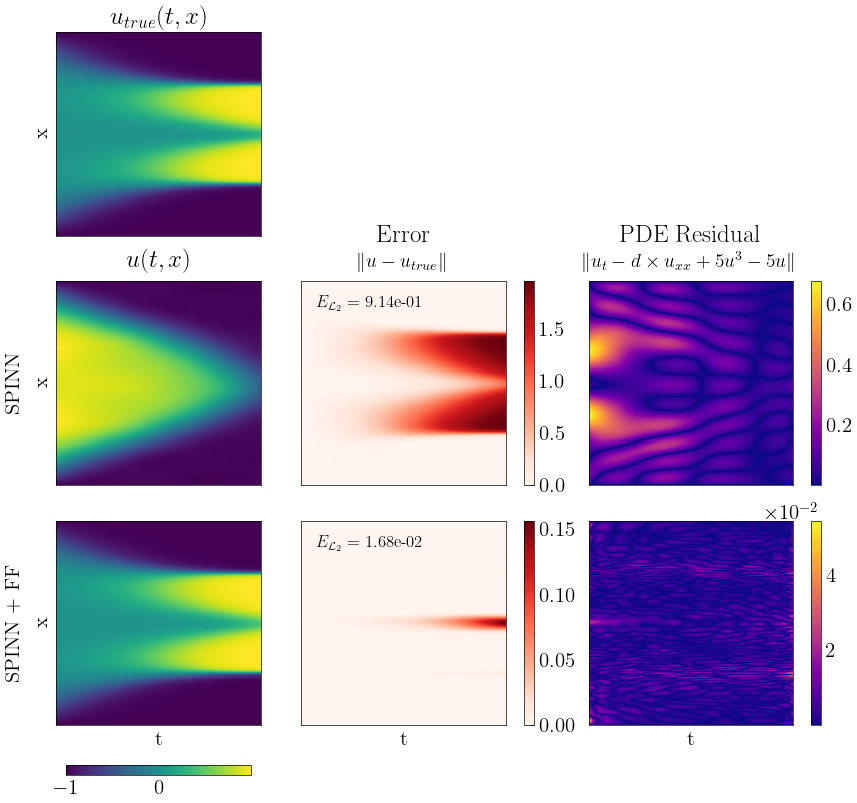

In [19]:
import matplotlib.transforms as mtransforms
from matplotlib import ticker

# --- Font size for printing ---
plotting_factor = 3
font_factor = 3
title_font_size = 6
axes_font_size = 5
plt.rcParams.update({
    "font.size": axes_font_size*font_factor,
    "figure.titlesize": title_font_size*font_factor,
    "axes.titlesize": title_font_size*font_factor,
})


config_to_plot_FF = ["pinn", "spinn", "spinn_mod"][1:2]
config_text_dict = {
    "pinn": "PINN",
    "pinn_FF": "PINN + FF",
    "spinn": "SPINN",
    "spinn_FF": "SPINN + FF",
    "spinn_mod": "SPINN-mod",
    "spinn_mod_FF": "SPINN-mod + FF",
}
X, y, xx, tt, u_true = test_data_allen_cahn(all_config_FF[config_to_plot_FF[0]], dataset_path=os.path.abspath("examples/allen_cahn/dataset/Allen_Cahn.mat"))

u_pred_all, u_diff_all, pde_loss_all, rows_title = [], [], [], []

def fields_from_config(config, all_data, config_text_dict=config_text_dict):
    u_pred_all, u_diff_all, pde_loss_all, rows_title = [], [], [], []
    for key in config:
        if key not in all_data: 
            continue
        e = all_data[key]["evaluation"]
        u_true = e["u_true"]
        u_pred_all.append(e["u_pred"])
        u_diff_all.append(e["u_pred"] - u_true)
        pde_loss_all.append(e["pde_loss"])
        rows_title.append((e.get("l2_error", 1e9), config_text_dict[key]))

    order = sorted(range(len(rows_title)), key=lambda i: rows_title[i][0], reverse=True)
    u_pred_all = [u_pred_all[i] for i in order]
    u_diff_all = [u_diff_all[i] for i in order]
    pde_loss_all = [pde_loss_all[i] for i in order]
    rows_title = [rows_title[i][1] for i in order]
    u_pred_all = [u_true] + u_pred_all
    return u_pred_all, u_diff_all, pde_loss_all, rows_title

config_to_plot_FF_and_suffix = [c + suffix for c in config_to_plot_FF for suffix in ("", "_FF")]
u_pred_all, u_diff_all, pde_loss_all, rows_title = fields_from_config(config_to_plot_FF_and_suffix, all_data_FF)
n_rows = len(rows_title) 

fields_FF = {
    "Solution": {
        "data": u_pred_all,
        "title": r"$u(t,x)$",
        "cmap": "viridis",
        "abs": False,
    },
    "Error": {
        "data": u_diff_all,
        "title": "Error\n" + r"\fontsize{14}{14} $\|u - u_{true}\|$",
        "cmap": "Reds",
        "abs": True,
    },
    "PDE Residual": {
        "data": pde_loss_all,
        "title": "PDE Residual\n" + r"\fontsize{14}{14}$\|u_t - d \times u_{xx} + 5u^3 - 5u\|$",
        "cmap": "plasma",
        "abs": True,
    },
}

fig, ax = plt.subplots(1+n_rows,3, figsize=(10.5,(1+n_rows)*3))

plot_allen_cahn_results(fig, ax, fields_FF, tt, xx, rows_title, font_factor, title_font_size, axes_font_size)

plt.show()

# save figure
figure_folder = os.path.join(results_folder, "IV_2_FourierFeatures_Figures")
os.makedirs(figure_folder, exist_ok=True)
figure_name = "+".join(config_to_plot_FF) + ".png"
fig.savefig(os.path.join(figure_folder, figure_name), bbox_inches='tight', dpi=300)

In [20]:
import pandas as pd
from IPython.display import display

#table of all results
# build a summary dataframe from all_data_FF
def build_results_df(all_data, config_text_dict=None, append_config=False):
    rows = []
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        evaluation = entry.get("evaluation", {})
        l2 = evaluation.get("l2_error", np.nan)
        mean_pde = evaluation.get("mean_pde_residual", np.nan)
        iters_per_s = entry.get("iterations_per_sec", np.nan)
        elapsed = entry.get("elapsed_time", np.nan)
        name = config_text_dict.get(key, key) if config_text_dict is not None else key

        rows.append({
            "model_name": name,
            "l2_error": float(l2) if np.isfinite(l2) else np.nan,
            "mean_pde_residual": float(mean_pde) if np.isfinite(mean_pde) else np.nan,
            "iterations_per_sec": float(iters_per_s) if np.isfinite(iters_per_s) else np.nan,
            "elapsed_time_min": float(elapsed)/60 if np.isfinite(elapsed) else np.nan,
        })

        if append_config:
            config = entry.get("config", {})
            for k, v in config.items():
                if k not in rows[-1]:
                    rows[-1][k] = v

    df = pd.DataFrame(rows)
    # sort by l2 error (descending as in original)
    df = df.sort_values("l2_error", ascending=False).reset_index(drop=True)
    return df

# Build dataframe from all_data_FF
append_config = False
df_results = build_results_df(all_data_FF, config_text_dict=config_text_dict, append_config=append_config)
# convert elapsed time from seconds to minutes and display

display(
    df_results.style
    .background_gradient(subset=["l2_error"], cmap="Greens_r")
    .format("{:.2e}", subset=["l2_error", "mean_pde_residual"])
    .format("{:.2f}", subset=["iterations_per_sec"])
    .format("{:.2f}", subset=["elapsed_time_min"])
    .set_properties(subset=["model_name"], **{"text-align": "left"})
)

# Save dataframe to latex
latex_folder = os.path.join(results_folder, "IV_2_FourierFeatures_Tables")
os.makedirs(latex_folder, exist_ok=True)
table_name = "one_run_config.tex" if append_config else "one_run.tex"
latex_file = os.path.join(latex_folder, table_name)
with open(latex_file, 'w') as f:
    f.write(df_results.to_latex(index=False, float_format="%.2e", column_format="lcccc", longtable=False))

,model_name,l2_error,mean_pde_residual,iterations_per_sec,elapsed_time_min
0,SPINN,9.14e-01,1.07e-01,538.36,0.93
1,PINN,2.23e-01,3.55e-02,1031.73,0.97
2,SPINN-mod,1.13e-01,1.22e-02,370.86,2.70
3,SPINN + FF,1.68e-02,3.17e-03,598.68,0.84
4,SPINN-mod + FF,9.84e-04,1.26e-03,419.91,2.38
5,PINN + FF,2.39e-04,9.10e-04,261.73,3.82


## IV_3: Adaptive Sampling and Attention

Adaptive sampling resamples points based on residuals. Attention focuses on important features.

In [21]:
results_file = os.path.join(results_folder, 'IV_2_SelfAttention.pkl')

# === Base configuration ===
base_config_SA = {
    "fourier_features": True,
    "n_fourier_features": 128,
    "sigma": 10,
    "net_type": "SPINN",
    "mlp_type": "mlp",
    "activations": "sin",
    "n_domain": 150**2,
    "lr": 1e-5,
    "lr_decay": ["warmup cosine", 1e-3, 1000, 80000, 1e-5], # cosine decay: peak lr, warmup iters, total iters, min lr
    "n_iter": 80000, 
    "rank": 64,
    "seed": 0,
    "SA": True,
}

# === Configs to run ===
config_to_run_SA = []  # e.g. ["pinn_SA", "spinn_SA", "spinn_mod_SA", "weight_vis"]

# === All model configs ===
all_config_SA = {
    "pinn_SA": {**base_config_SA, "net_type": "PINN", "n_fourier_features": 256},
    "spinn_SA": {**base_config_SA, "net_type": "SPINN"},
    "spinn_mod_SA": {**base_config_SA, "net_type": "SPINN", "mlp_type": "mlp_mod"},
    "weight_vis": {**base_config_SA,"lr": 1e-3,"lr_decay": ["warmup cosine", 1e-3, 3000, 50000, 1e-5]}
}

all_config_names_SA = list(all_config_SA.keys())


iters_pde_w = [500, 2500, 47000]
all_data_SA, all_models_SA = {}, {}

# === Load existing results ===
try:
    with open(results_file, 'rb') as f:
        saved_results = pickle.load(f)
except Exception:
    saved_results = {}

# === Run or load each configuration ===
for config_name in config_to_run_SA:
    print(f"Running configuration: {config_name}")
    config_SA = all_config_SA[config_name]

    if config_name == "weight_vis":
        results_weight_vis = {}
        data_weight_vis = train_allen_cahn({**config_SA, "lr": 1e-3, "n_iter": 0})
        model = data_weight_vis.pop('model')

        for i, iter_ in enumerate(iters_pde_w):
            loss_history, _ = model.train(iter_)
            total_iter = sum(iters_pde_w[:i+1])
            results_weight_vis[total_iter] = eval_allen_cahn(config_SA, model)
            results_weight_vis[total_iter]["pde_weights"] = model.external_trainable_variables[0].value
            print(f"Iter {total_iter}: L2={results_weight_vis[total_iter]['l2_error']:.3e}, "
                  f"PDE={results_weight_vis[total_iter]['mean_pde_residual']:.3e}")

        all_models_SA[config_name] = model
        data = {**data_weight_vis, "results": results_weight_vis}
        all_data_SA[config_name] = data

    else:
        data = train_allen_cahn(config_SA)
        all_models_SA[config_name] = data.pop('model')
        all_data_SA[config_name] = data

    saved_results[config_name] = {**data, "model_params": all_models_SA[config_name].net.params}

# Save updated results back
with open(results_file, 'wb') as f:
    pickle.dump(saved_results, f)


restore_models = False  # Whether to reconstruct the models from saved params

# Load saved results if not all configs were run
if len(config_to_run_SA) < len(all_config_names_SA):
    try:
        with open(results_file, 'rb') as f:
            saved = pickle.load(f)
    except Exception:
        saved = {}

    for config_name in all_config_names_SA:
        if config_name in config_to_run_SA:
            continue
        key = config_name
        if key not in saved:
            print(f"Warning: {key} not found in saved results.")
            continue
        print(f"Loading saved results for: {key}")
        data = saved[key]
        all_data_SA[key] = {k: v for k, v in data.items() if k != "model_params"}
        if "model_params" in data:
            all_models_SA[key] = data["model_params"]

        if restore_models and "model_params" in data and "config" in data:
            try:
                all_models_SA[key] = train_allen_cahn({
                    **data["config"],
                    "lr": 1e-3,
                    "n_iter": 0,
                    "restored_params": data["model_params"],
                })["model"]
            except Exception:
                pass


Loading saved results for: pinn_SA
Loading saved results for: spinn_SA
Loading saved results for: spinn_mod_SA
Loading saved results for: weight_vis


In [25]:
X, y, xx, tt, u_true = test_data_allen_cahn(base_config_SA, dataset_path=os.path.abspath("examples/allen_cahn/dataset/Allen_Cahn.mat"))
X_train = [np.linspace(-1,1,150),np.linspace(0,1,150)] #all_models_SA["weight_vis"].data.train_x[0]
x_train, t_train = np.meshgrid(X_train[0], X_train[1])

# Plot evaluation at different PDE weight iterations using results_SA
u_pred_all, pde_loss_all, pde_weights_all = [], [], []
results_weight_vis = all_data_SA["weight_vis"]["results"]
for k in sorted(results_weight_vis.keys()):
    u_pred_all.append(results_weight_vis[k]["u_pred"])
    pde_loss_all.append(results_weight_vis[k]["pde_loss"])
    pde_weights_all.append(results_weight_vis[k]["pde_weights"].reshape(x_train.shape).T)

# Use ground truth from any entry (they are the same)
u_true = results_weight_vis[min(results_weight_vis.keys())]["u_true"]
u_diff_all = [u - u_true for u in u_pred_all]

rows_title = [f"After {k} iters" for k in sorted(results_weight_vis.keys())]

fields_SA_weight_vis = {
    "Solution": {
        "data": [u_true] + u_pred_all,
        "title": r"$u(t,x)$",
        "cmap": None,
        "abs": False,
    },
    "Error": {
        "data": u_diff_all,
        "title": "Error\n" + r"\fontsize{14}{14} $\|u - u_{true}\|$",
        "cmap": "Reds",
        "abs": True,
    },
    "PDE Residual": {
        "data": pde_loss_all,
        "title": "PDE Residual\n" + r"\fontsize{14}{14}$\|u_t - d \times u_{xx} + 5u^3 - 5u\|$",
        "cmap": "plasma",
        "abs": True,
    },
    "PDE Weights": {
        "data": pde_weights_all,
        "title": "PDE Weights\n" + r"\fontsize{14}{14}$w_{PDE}$",
        "cmap": "Greys_r",
        "abs": False,
        "x_fields": x_train,
        "t_fields": t_train,
    },
}
fig, ax = plt.subplots(4,4, figsize=(14.5,12))
plot_allen_cahn_results(fig, ax, fields_SA_weight_vis, tt, xx, rows_title)
plt.show()

TypeError: 'float' object is not subscriptable

Fig width: 10.5, set it to 3.50 < 6.34 (A4 with margins) in latex to have a printed font size of 6.00 for titles and 5.00 for the axis


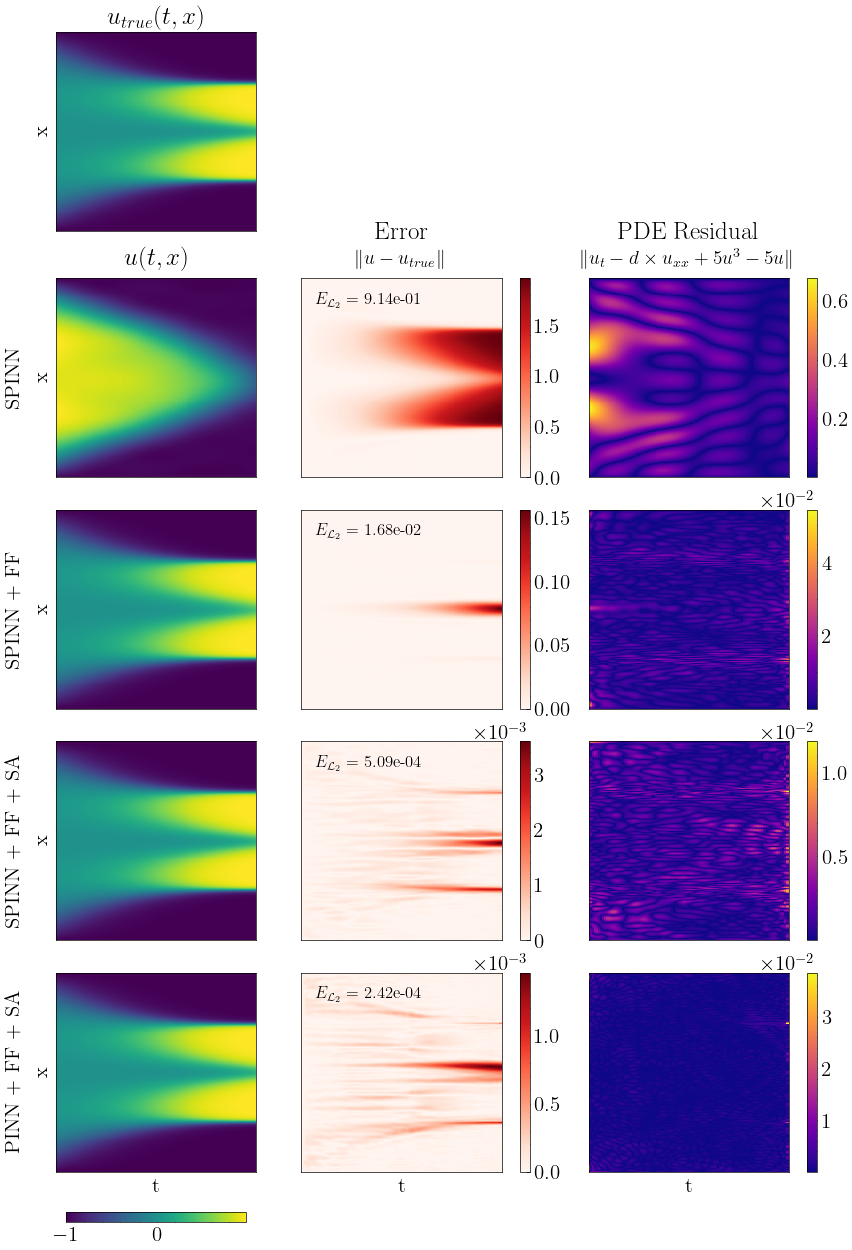

In [26]:
all_data_FF_SA = {**all_data_FF, **all_data_SA}
config_to_plot_FF_SA = ["spinn", "spinn_FF", "spinn_SA", "pinn_SA"]

config_text_dict_FF_SA = copy.deepcopy(config_text_dict)
config_text_dict_FF_SA.update({
    "pinn_SA": "PINN + FF + SA",
    "spinn_SA": "SPINN + FF + SA",
    "spinn_mod_SA": "SPINN-mod + FF + SA",
})

u_pred_all, u_diff_all, pde_loss_all, rows_title = fields_from_config(config_to_plot_FF_SA, all_data_FF_SA, config_text_dict_FF_SA)
n_rows = len(rows_title) 

fields_FF_SA = copy.deepcopy(fields_FF)
fields_FF_SA["Solution"]["data"] = u_pred_all
fields_FF_SA["Error"]["data"] = u_diff_all
fields_FF_SA["PDE Residual"]["data"] = pde_loss_all

fig, ax = plt.subplots(1+n_rows,3, figsize=(10.5,(1+n_rows)*3))

plot_allen_cahn_results(fig, ax, fields_FF_SA, tt, xx, rows_title)

In [27]:
# Build dataframe from all_data_FF
append_config = False
df_results = build_results_df(all_data_FF_SA, config_text_dict=config_text_dict_FF_SA, append_config=append_config)
# remove any "weight_vis" rows from the results table and reset index
df_results = df_results[~df_results["model_name"].astype(str).str.contains("weight_vis", case=False)].reset_index(drop=True)
# convert elapsed time from seconds to minutes and display

display(
    df_results.style
    .background_gradient(subset=["l2_error"], cmap="Greens_r")
    .format("{:.2e}", subset=["l2_error", "mean_pde_residual"])
    .format("{:.2f}", subset=["iterations_per_sec"])
    .format("{:.2f}", subset=["elapsed_time_min"])
    .set_properties(subset=["model_name"], **{"text-align": "left"})
)

# Save dataframe to latex
latex_folder = os.path.join(results_folder, "IV_2_SelfAttention_Tables")
os.makedirs(latex_folder, exist_ok=True)
table_name = "one_run_config.tex" if append_config else "one_run.tex"
latex_file = os.path.join(latex_folder, table_name)
with open(latex_file, 'w') as f:
    f.write(df_results.to_latex(index=False, float_format="%.2e", column_format="lcccc", longtable=False))

,model_name,l2_error,mean_pde_residual,iterations_per_sec,elapsed_time_min
0,SPINN,9.14e-01,1.07e-01,538.36,0.93
1,PINN,2.23e-01,3.55e-02,1031.73,0.97
2,SPINN-mod,1.13e-01,1.22e-02,370.86,2.70
3,SPINN + FF,1.68e-02,3.17e-03,598.68,0.84
4,SPINN-mod + FF + SA,1.67e-03,2.07e-03,367.68,3.63
5,SPINN-mod + FF,9.84e-04,1.26e-03,419.91,2.38
6,SPINN + FF + SA,5.09e-04,1.09e-03,284.13,4.69
7,PINN + FF + SA,2.42e-04,6.83e-04,270.55,4.93
8,PINN + FF,2.39e-04,9.10e-04,261.73,3.82


## IV_4: Hyperparameter Optimization with Wandb Sweeps

Use Wandb sweeps for systematic hyperparameter optimization. The sweep configurations below are based on the YAML files in `examples/allen_cahn/HPO/`.

In [ ]:
# === Wandb Sweep Configuration & Runner ===
import wandb, yaml, os

# Results storage - both for CSVs and wandb local files
sweep_results_folder = os.path.join(results_folder, 'HyperparameterSearch')
os.makedirs(sweep_results_folder, exist_ok=True)

# Set wandb local directory (instead of default ./wandb/)
os.environ['WANDB_DIR'] = sweep_results_folder
os.environ['WANDB_DATA_DIR'] = os.path.join(sweep_results_folder, "wandb_cache")

# Create wandb sweep configs
sweep_config_pinn = {
    'method': 'grid',
    'metric': {'name': 'l2_relative_error', 'goal': 'minimize'},
    'parameters': {
        'net_type': {'value': 'PINN'},
        'n_fourier_features': {'values': [128, 256]},
        'activations': {'values': ['tanh', 'sin']},
        'n_domain': {'value': 22500}, #150**2
        'n_iter': {'value': 80000},
        'seed': {'values': [0, 1, 2, 3]},
        'fourier_features': {'value': True},
        'lr': {'value': 1e-5},
        'lr_decay': {'values': [['warmup cosine', 1e-3, 1000, 80000, 1e-5],
                                ['exponential', 1e-3, 1000, 0.9]]},
        'SA': {'value': True},
    }
}

sweep_config_spinn = {
    'method': 'grid',
    'metric': {'name': 'l2_relative_error', 'goal': 'minimize'},
    'parameters': {
        'net_type': {'value': 'SPINN'},
        'n_fourier_features': {'values': [64, 128]},
        'activations': {'values': ['tanh', 'sin']},
        'n_domain': {'values': [22500, 40000]}, #150**2/200**2
        'mlp_type': {'values': ['mlp', 'modified-mlp']},
        'rank': {'values': [32, 64]},
        'seed': {'values': [0, 1, 2, 3]},
        'fourier_features': {'value': True},
        'n_iter': {'value': 80000},
        'lr': {'value': 1e-5},
        'lr_decay': {'values': [['warmup cosine', 1e-3, 1000, 80000, 1e-5],
                                ['exponential', 1e-3, 1000, 0.9]]},
        'SA': {'value': True},
    }
}

# Training function
def train_wandb():
    # Initialize wandb run (sweep agent doesn't do this automatically)
    run = wandb.init()
    train_allen_cahn(wandb_project=run.project)
    wandb.finish()

# Run sweep
RUN_SWEEP = True
SWEEP_TYPE = 'spinn'  # 'pinn' or 'spinn'
sweep_ids = {'pinn': None, 'spinn': None}
if RUN_SWEEP:
    sweep_config = sweep_config_spinn if SWEEP_TYPE == 'spinn' else sweep_config_pinn
    project_name = f'Allen-Cahn'
    
    if sweep_ids[SWEEP_TYPE] is not None:
        sweep_id = sweep_ids[SWEEP_TYPE]
        print(f"Using existing sweep ID: {sweep_id}")
    else:
        sweep_id = wandb.sweep(sweep_config, project=project_name)

    print(f"Created sweep: {sweep_id}")
    print(f"Results will be stored in wandb and locally in: {sweep_results_folder}")
    
    # Run agent locally
    wandb.agent(sweep_id, train_wandb, count=None)  # Set count=None for all runs
else:
    def count_combinations(cfg):
        return np.prod([len(p['values']) if 'values' in p else 1 for p in cfg['parameters'].values()])
    print(f"Set RUN_SWEEP=True to start sweep")
    print(f"PINN: ~{count_combinations(sweep_config_pinn)} combinations")
    print(f"SPINN: ~{count_combinations(sweep_config_spinn)} combinations")
    print(f"Results folder: {sweep_results_folder}")


Create sweep with ID: q6msof4r
Sweep URL: https://wandb.ai/damien-bonnet/Allen-Cahn/sweeps/q6msof4r
Created sweep: q6msof4r
Results will be stored in wandb and locally in: results/IV_ImprovingTraining/HyperparameterSearch


wandb: Agent Starting Run: u71wvrqj with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0
wandb: Currently logged in as: damien-bonnet to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: damien-bonnet to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Set the default automatic differentiation to forward mode.
Compiling model...
Compiling model...
'compile' took 6.467835 s

'compile' took 6.467835 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
Step      Train loss    Test loss     Test metric
0         [8.01e+00]    [8.01e+00]    []  
0         [8.01e+00]    [8.01e+00]    []  
1000      [2.24e-02]    [2.24e-02]    []  
1000      [2.24e-02]    [2.24e-02]    []  
2000      [8.89e-03]    [8.89e-03]    []  
2000      [8.89e-03]    [8.89e-03]    []  
3000      [2.82e-03]    [2.82e-03]    []  
3000      [2.82e-03]    [2.82e-03]    []  
4000      [1.70e-03]    [1.70e-03]    []  
4000      [1.70e-03]    [1.70e-03]    []  
5000      [3.23e-03]    [3.23e-03]    []  
5000      [3.23e-03]    [3.23e-03]    []  
6000      [1.39e-03]    [1.39e-03]    []  
6000      [1.39e-03]    [1.39e-03]    []  
7000      [2.41e-03]    [2.41e-03]    []  
7000      [2.41e-03]    [2.41e-03]    []  
8000      [1.14e-03]   

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 2.088e-03
L2 relative error: 4.372e-03
Elapsed training time: 190.56 s, 419.81 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: ycnt70zs with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.068964 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.09e+01]    [1.09e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.09e+01]    [1.09e+01]    []  
1000      [3.74e-02]    [3.74e-02]    []  
1000      [3.74e-02]    [3.74e-02]    []  
2000      [8.36e-03]    [8.36e-03]    []  
2000      [8.36e-03]    [8.36e-03]    []  
3000      [4.92e-03]    [4.92e-03]    []  
3000      [4.92e-03]    [4.92e-03]    []  
4000      [4.17e-03]    [4.17e-03]    []  
4000      [4.17e-03]    [4.17e-03]    []  
5000      [3.60e-03]    [3.60e-03]    []  
5000      [3.60e-03]    [3.60e-03]    []  
6000      [1.67e-03]    [1.67e-03]    []  
6000      [1.67e-03]    [1.67e-03]    []  
7000      [6.20e-04]    [6.20e-04]    []  
7000      [6.20e-04]    [6.20e-04]    []  
8000      [2.16e-03]    [2.16e-03]    []  
8000      [2.16e-03]    [2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.537e-03
L2 relative error: 2.614e-03
Elapsed training time: 277.75 s, 288.03 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 0k2cd9gx with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.070343 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.13e+01]    [1.13e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.13e+01]    [1.13e+01]    []  
1000      [3.85e-02]    [3.85e-02]    []  
1000      [3.85e-02]    [3.85e-02]    []  
2000      [2.69e-02]    [2.69e-02]    []  
2000      [2.69e-02]    [2.69e-02]    []  
3000      [1.01e-02]    [1.01e-02]    []  
3000      [1.01e-02]    [1.01e-02]    []  
4000      [3.81e-03]    [3.81e-03]    []  
4000      [3.81e-03]    [3.81e-03]    []  
5000      [1.63e-03]    [1.63e-03]    []  
5000      [1.63e-03]    [1.63e-03]    []  
6000      [3.21e-03]    [3.21e-03]    []  
6000      [3.21e-03]    [3.21e-03]    []  
7000      [1.02e-03]    [1.02e-03]    []  
7000      [1.02e-03]    [1.02e-03]    []  
8000      [9.08e-04]    [9.08e-04]    []  
8000      [9.08e-04]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.727e-03
L2 relative error: 2.608e-03
Elapsed training time: 180.58 s, 443.02 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: llq7mvnv with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.069849 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [5.36e+00]    [5.36e+00]    []  
Step      Train loss    Test loss     Test metric
0         [5.36e+00]    [5.36e+00]    []  
1000      [2.60e-02]    [2.60e-02]    []  
1000      [2.60e-02]    [2.60e-02]    []  
2000      [1.74e-02]    [1.74e-02]    []  
2000      [1.74e-02]    [1.74e-02]    []  
3000      [2.48e-03]    [2.48e-03]    []  
3000      [2.48e-03]    [2.48e-03]    []  
4000      [1.27e-03]    [1.27e-03]    []  
4000      [1.27e-03]    [1.27e-03]    []  
5000      [6.52e-04]    [6.52e-04]    []  
5000      [6.52e-04]    [6.52e-04]    []  
6000      [6.59e-04]    [6.59e-04]    []  
6000      [6.59e-04]    [6.59e-04]    []  
7000      [9.72e-04]    [9.72e-04]    []  
7000      [9.72e-04]    [9.72e-04]    []  
8000      [3.42e-03]    [3.42e-03]    []  
8000      [3.42e-03]    [3

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.397e-03
L2 relative error: 2.227e-03
Elapsed training time: 299.93 s, 266.73 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: qj74wt86 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.782147 s

'compile' took 0.782147 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
Step      Train loss    Test loss     Test metric
0         [6.36e+00]    [6.36e+00]    []  
0         [6.36e+00]    [6.36e+00]    []  
1000      [2.23e-02]    [2.23e-02]    []  
1000      [2.23e-02]    [2.23e-02]    []  
2000      [2.37e-02]    [2.37e-02]    []  
2000      [2.37e-02]    [2.37e-02]    []  
3000      [2.56e-03]    [2.56e-03]    []  
3000      [2.56e-03]    [2.56e-03]    []  
4000      [4.35e-03]    [4.35e-03]    []  
4000      [4.35e-03]    [4.35e-03]    []  
5000      [1.16e-03]    [1.16e-03]    []  
5000      [1.16e-03]    [1.16e-03]    []  
6000      [1.57e-03]    [1.57e-03]    []  
6000      [1.57e-03]    [1.57e-03]    []  
7000      [2.63e-03]    [2.63e-03]    []  
7000      [2.63e-03]    [2.63e-03]    []  
8000      [1.38e-03]    [1.38e-03]    []  

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.797e-03
L2 relative error: 1.643e-03
Elapsed training time: 287.09 s, 278.66 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: ucax6jcx with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.176310 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.47e+01]    [1.47e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.47e+01]    [1.47e+01]    []  
1000      [4.58e-02]    [4.58e-02]    []  
1000      [4.58e-02]    [4.58e-02]    []  
2000      [2.08e-02]    [2.08e-02]    []  
2000      [2.08e-02]    [2.08e-02]    []  
3000      [4.37e-03]    [4.37e-03]    []  
3000      [4.37e-03]    [4.37e-03]    []  
4000      [2.27e-03]    [2.27e-03]    []  
4000      [2.27e-03]    [2.27e-03]    []  
5000      [3.00e-03]    [3.00e-03]    []  
5000      [3.00e-03]    [3.00e-03]    []  
6000      [1.73e-03]    [1.73e-03]    []  
6000      [1.73e-03]    [1.73e-03]    []  
7000      [2.41e-03]    [2.41e-03]    []  
7000      [2.41e-03]    [2.41e-03]    []  
8000      [8.18e-04]    [8.18e-04]    []  
8000      [8.18e-04]    [8

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.255e-03
L2 relative error: 1.572e-03
Elapsed training time: 186.83 s, 428.21 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: pl39r6af with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.121605 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [8.43e+00]    [8.43e+00]    []  
Step      Train loss    Test loss     Test metric
0         [8.43e+00]    [8.43e+00]    []  
1000      [2.54e-02]    [2.54e-02]    []  
1000      [2.54e-02]    [2.54e-02]    []  
2000      [2.39e-02]    [2.39e-02]    []  
2000      [2.39e-02]    [2.39e-02]    []  
3000      [4.82e-03]    [4.82e-03]    []  
3000      [4.82e-03]    [4.82e-03]    []  
4000      [2.75e-03]    [2.75e-03]    []  
4000      [2.75e-03]    [2.75e-03]    []  
5000      [3.68e-03]    [3.68e-03]    []  
5000      [3.68e-03]    [3.68e-03]    []  
6000      [1.20e-03]    [1.20e-03]    []  
6000      [1.20e-03]    [1.20e-03]    []  
7000      [2.00e-03]    [2.00e-03]    []  
7000      [2.00e-03]    [2.00e-03]    []  
8000      [6.30e-03]    [6.30e-03]    []  
8000      [6.30e-03]    [6

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.701e-03
L2 relative error: 2.443e-03
Elapsed training time: 201.99 s, 396.07 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 3hp3myai with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.140324 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [6.52e+00]    [6.52e+00]    []  
Step      Train loss    Test loss     Test metric
0         [6.52e+00]    [6.52e+00]    []  
1000      [2.71e-02]    [2.71e-02]    []  
1000      [2.71e-02]    [2.71e-02]    []  
2000      [1.82e-02]    [1.82e-02]    []  
2000      [1.82e-02]    [1.82e-02]    []  
3000      [3.09e-03]    [3.09e-03]    []  
3000      [3.09e-03]    [3.09e-03]    []  
4000      [2.65e-03]    [2.65e-03]    []  
4000      [2.65e-03]    [2.65e-03]    []  
5000      [1.04e-03]    [1.04e-03]    []  
5000      [1.04e-03]    [1.04e-03]    []  
6000      [2.10e-03]    [2.10e-03]    []  
6000      [2.10e-03]    [2.10e-03]    []  
7000      [8.04e-04]    [8.04e-04]    []  
7000      [8.04e-04]    [8.04e-04]    []  
8000      [9.28e-03]    [9.28e-03]    []  
8000      [9.28e-03]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.640e-03
L2 relative error: 3.667e-03
Elapsed training time: 203.47 s, 393.17 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: y0kj6bdl with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.987651 s

'compile' took 0.987651 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.28e+01]    [1.28e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.28e+01]    [1.28e+01]    []  
1000      [2.30e-02]    [2.30e-02]    []  
1000      [2.30e-02]    [2.30e-02]    []  
2000      [9.25e-03]    [9.25e-03]    []  
2000      [9.25e-03]    [9.25e-03]    []  
3000      [2.78e-03]    [2.78e-03]    []  
3000      [2.78e-03]    [2.78e-03]    []  
4000      [3.45e-03]    [3.45e-03]    []  
4000      [3.45e-03]    [3.45e-03]    []  
5000      [1.93e-03]    [1.93e-03]    []  
5000      [1.93e-03]    [1.93e-03]    []  
6000      [1.02e-03]    [1.02e-03]    []  
6000      [1.02e-03]    [1.02e-03]    []  
7000      [8.45e-04]    [8.45e-04]    []  
7000      [8.45e-04]    [8.45e-04]    []  
8000      [8.84e-04]    [8.84e-04]    []  

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.663e-03
L2 relative error: 3.098e-03
Elapsed training time: 198.93 s, 402.15 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: kmiv92gv with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.170226 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.62e+01]    [1.62e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.62e+01]    [1.62e+01]    []  
1000      [4.03e-02]    [4.03e-02]    []  
1000      [4.03e-02]    [4.03e-02]    []  
2000      [2.83e-02]    [2.83e-02]    []  
2000      [2.83e-02]    [2.83e-02]    []  
3000      [3.47e-03]    [3.47e-03]    []  
3000      [3.47e-03]    [3.47e-03]    []  
4000      [1.57e-03]    [1.57e-03]    []  
4000      [1.57e-03]    [1.57e-03]    []  
5000      [1.10e-03]    [1.10e-03]    []  
5000      [1.10e-03]    [1.10e-03]    []  
6000      [1.07e-03]    [1.07e-03]    []  
6000      [1.07e-03]    [1.07e-03]    []  
7000      [1.01e-03]    [1.01e-03]    []  
7000      [1.01e-03]    [1.01e-03]    []  
8000      [5.90e-04]    [5.90e-04]    []  
8000      [5.90e-04]    [5

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.446e-03
L2 relative error: 1.661e-03
Elapsed training time: 191.73 s, 417.26 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: tqoy3uey with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.153281 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
Step      Train loss    Test loss     Test metric
0         [1.58e+01]    [1.58e+01]    []  
0         [1.58e+01]    [1.58e+01]    []  
1000      [5.00e-02]    [5.00e-02]    []  
1000      [5.00e-02]    [5.00e-02]    []  
2000      [1.28e-02]    [1.28e-02]    []  
2000      [1.28e-02]    [1.28e-02]    []  
3000      [4.09e-03]    [4.09e-03]    []  
3000      [4.09e-03]    [4.09e-03]    []  
4000      [2.85e-03]    [2.85e-03]    []  
4000      [2.85e-03]    [2.85e-03]    []  
5000      [3.14e-03]    [3.14e-03]    []  
5000      [3.14e-03]    [3.14e-03]    []  
6000      [5.39e-03]    [5.39e-03]    []  
6000      [5.39e-03]    [5.39e-03]    []  
7000      [7.73e-04]    [7.73e-04]    []  
7000      [7.73e-04]    [7.73e-04]    []  
8000      [1.18e-03]    [1.18e-03]    []  
8000      [1.18e-03]    [1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.231e-03
L2 relative error: 1.388e-03
Elapsed training time: 161.04 s, 496.79 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 3eeln9lj with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3
wandb: 	rank: 32
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.089624 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [5.67e+00]    [5.67e+00]    []  
Step      Train loss    Test loss     Test metric
0         [5.67e+00]    [5.67e+00]    []  
1000      [1.92e-02]    [1.92e-02]    []  
1000      [1.92e-02]    [1.92e-02]    []  
2000      [4.00e-03]    [4.00e-03]    []  
2000      [4.00e-03]    [4.00e-03]    []  
3000      [1.34e-03]    [1.34e-03]    []  
3000      [1.34e-03]    [1.34e-03]    []  
4000      [2.02e-03]    [2.02e-03]    []  
4000      [2.02e-03]    [2.02e-03]    []  
5000      [5.62e-04]    [5.62e-04]    []  
5000      [5.62e-04]    [5.62e-04]    []  
6000      [5.19e-04]    [5.19e-04]    []  
6000      [5.19e-04]    [5.19e-04]    []  
7000      [8.88e-04]    [8.88e-04]    []  
7000      [8.88e-04]    [8.88e-04]    []  
8000      [2.59e-03]    [2.59e-03]    []  
8000      [2.59e-03]    [2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.470e-03
L2 relative error: 1.990e-03
Elapsed training time: 211.66 s, 377.96 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 08zb3h3r with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.063722 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
Step      Train loss    Test loss     Test metric
0         [2.50e+01]    [2.50e+01]    []  
0         [2.50e+01]    [2.50e+01]    []  
1000      [8.13e-02]    [8.13e-02]    []  
1000      [8.13e-02]    [8.13e-02]    []  
2000      [1.22e-02]    [1.22e-02]    []  
2000      [1.22e-02]    [1.22e-02]    []  
3000      [5.68e-03]    [5.68e-03]    []  
3000      [5.68e-03]    [5.68e-03]    []  
4000      [3.09e-03]    [3.09e-03]    []  
4000      [3.09e-03]    [3.09e-03]    []  
5000      [1.89e-03]    [1.89e-03]    []  
5000      [1.89e-03]    [1.89e-03]    []  
6000      [1.41e-03]    [1.41e-03]    []  
6000      [1.41e-03]    [1.41e-03]    []  
7000      [1.36e-03]    [1.36e-03]    []  
7000      [1.36e-03]    [1.36e-03]    []  
8000      [9.49e-04]    [9.49e-04]    []  
8000      [9.49e-04]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.684e-03
L2 relative error: 2.387e-03
Elapsed training time: 169.92 s, 470.81 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4c93frjt with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: Job received.
wandb: Agent Starting Run: 4c93frjt with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.063048 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.18e+01]    [1.18e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.18e+01]    [1.18e+01]    []  
1000      [2.50e-02]    [2.50e-02]    []  
1000      [2.50e-02]    [2.50e-02]    []  
2000      [1.46e-02]    [1.46e-02]    []  
2000      [1.46e-02]    [1.46e-02]    []  
3000      [2.42e-03]    [2.42e-03]    []  
3000      [2.42e-03]    [2.42e-03]    []  
4000      [2.75e-03]    [2.75e-03]    []  
4000      [2.75e-03]    [2.75e-03]    []  
5000      [2.57e-03]    [2.57e-03]    []  
5000      [2.57e-03]    [2.57e-03]    []  
6000      [1.66e-03]    [1.66e-03]    []  
6000      [1.66e-03]    [1.66e-03]    []  
7000      [1.81e-03]    [1.81e-03]    []  
7000      [1.81e-03]    [1.81e-03]    []  
8000      [7.68e-04]    [7.68e-04]    []  
8000      [7.68e-04]    [7

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.281e-03
L2 relative error: 1.769e-03
Elapsed training time: 183.71 s, 435.47 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: sjstqjvm with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.113833 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [6.47e+00]    [6.47e+00]    []  
Step      Train loss    Test loss     Test metric
0         [6.47e+00]    [6.47e+00]    []  
1000      [2.03e-02]    [2.03e-02]    []  
1000      [2.03e-02]    [2.03e-02]    []  
2000      [1.37e-02]    [1.37e-02]    []  
2000      [1.37e-02]    [1.37e-02]    []  
3000      [1.73e-03]    [1.73e-03]    []  
3000      [1.73e-03]    [1.73e-03]    []  
4000      [1.15e-03]    [1.15e-03]    []  
4000      [1.15e-03]    [1.15e-03]    []  
5000      [1.19e-03]    [1.19e-03]    []  
5000      [1.19e-03]    [1.19e-03]    []  
6000      [6.99e-03]    [6.99e-03]    []  
6000      [6.99e-03]    [6.99e-03]    []  
7000      [4.22e-04]    [4.22e-04]    []  
7000      [4.22e-04]    [4.22e-04]    []  
8000      [9.10e-04]    [9.10e-04]    []  
8000      [9.10e-04]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.267e-03
L2 relative error: 1.117e-03
Elapsed training time: 189.09 s, 423.08 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 1jphou42 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.116189 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [6.13e+00]    [6.13e+00]    []  
Step      Train loss    Test loss     Test metric
0         [6.13e+00]    [6.13e+00]    []  
1000      [2.14e-02]    [2.14e-02]    []  
1000      [2.14e-02]    [2.14e-02]    []  
2000      [1.12e-02]    [1.12e-02]    []  
2000      [1.12e-02]    [1.12e-02]    []  
3000      [1.67e-03]    [1.67e-03]    []  
3000      [1.67e-03]    [1.67e-03]    []  
4000      [1.13e-03]    [1.13e-03]    []  
4000      [1.13e-03]    [1.13e-03]    []  
5000      [1.13e-03]    [1.13e-03]    []  
5000      [1.13e-03]    [1.13e-03]    []  
6000      [5.59e-04]    [5.59e-04]    []  
6000      [5.59e-04]    [5.59e-04]    []  
7000      [7.03e-04]    [7.03e-04]    []  
7000      [7.03e-04]    [7.03e-04]    []  
8000      [9.49e-04]    [9.49e-04]    []  
8000      [9.49e-04]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.841e-03
L2 relative error: 2.538e-03
Elapsed training time: 183.85 s, 435.13 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: i4nyfhay with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.128857 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [8.01e+00]    [8.01e+00]    []  
Step      Train loss    Test loss     Test metric
0         [8.01e+00]    [8.01e+00]    []  
1000      [2.24e-02]    [2.24e-02]    []  
1000      [2.24e-02]    [2.24e-02]    []  
2000      [8.89e-03]    [8.89e-03]    []  
2000      [8.89e-03]    [8.89e-03]    []  
3000      [2.82e-03]    [2.82e-03]    []  
3000      [2.82e-03]    [2.82e-03]    []  
4000      [1.70e-03]    [1.70e-03]    []  
4000      [1.70e-03]    [1.70e-03]    []  
5000      [3.23e-03]    [3.23e-03]    []  
5000      [3.23e-03]    [3.23e-03]    []  
6000      [1.39e-03]    [1.39e-03]    []  
6000      [1.39e-03]    [1.39e-03]    []  
7000      [2.41e-03]    [2.41e-03]    []  
7000      [2.41e-03]    [2.41e-03]    []  
8000      [1.14e-03]    [1.14e-03]    []  
8000      [1.14e-03]    [1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 2.088e-03
L2 relative error: 4.372e-03
Elapsed training time: 212.89 s, 375.78 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: f4v9mgc1 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.110375 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.09e+01]    [1.09e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.09e+01]    [1.09e+01]    []  
1000      [3.74e-02]    [3.74e-02]    []  
1000      [3.74e-02]    [3.74e-02]    []  
2000      [8.36e-03]    [8.36e-03]    []  
2000      [8.36e-03]    [8.36e-03]    []  
3000      [4.92e-03]    [4.92e-03]    []  
3000      [4.92e-03]    [4.92e-03]    []  
4000      [4.17e-03]    [4.17e-03]    []  
4000      [4.17e-03]    [4.17e-03]    []  
5000      [3.60e-03]    [3.60e-03]    []  
5000      [3.60e-03]    [3.60e-03]    []  
6000      [1.67e-03]    [1.67e-03]    []  
6000      [1.67e-03]    [1.67e-03]    []  
7000      [6.20e-04]    [6.20e-04]    []  
7000      [6.20e-04]    [6.20e-04]    []  
8000      [2.16e-03]    [2.16e-03]    []  
8000      [2.16e-03]    [2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.537e-03
L2 relative error: 2.614e-03
Elapsed training time: 208.10 s, 384.42 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: cygww9hs with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.089854 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.13e+01]    [1.13e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.13e+01]    [1.13e+01]    []  
1000      [3.85e-02]    [3.85e-02]    []  
1000      [3.85e-02]    [3.85e-02]    []  
2000      [2.69e-02]    [2.69e-02]    []  
2000      [2.69e-02]    [2.69e-02]    []  
3000      [1.01e-02]    [1.01e-02]    []  
3000      [1.01e-02]    [1.01e-02]    []  
4000      [3.81e-03]    [3.81e-03]    []  
4000      [3.81e-03]    [3.81e-03]    []  
5000      [1.63e-03]    [1.63e-03]    []  
5000      [1.63e-03]    [1.63e-03]    []  
6000      [3.21e-03]    [3.21e-03]    []  
6000      [3.21e-03]    [3.21e-03]    []  
7000      [1.02e-03]    [1.02e-03]    []  
7000      [1.02e-03]    [1.02e-03]    []  
8000      [9.08e-04]    [9.08e-04]    []  
8000      [9.08e-04]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.727e-03
L2 relative error: 2.608e-03
Elapsed training time: 170.36 s, 469.59 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: u5v6x7p5 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.111118 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
Step      Train loss    Test loss     Test metric
0         [5.36e+00]    [5.36e+00]    []  
0         [5.36e+00]    [5.36e+00]    []  
1000      [2.60e-02]    [2.60e-02]    []  
1000      [2.60e-02]    [2.60e-02]    []  
2000      [1.74e-02]    [1.74e-02]    []  
2000      [1.74e-02]    [1.74e-02]    []  
3000      [2.48e-03]    [2.48e-03]    []  
3000      [2.48e-03]    [2.48e-03]    []  
4000      [1.27e-03]    [1.27e-03]    []  
4000      [1.27e-03]    [1.27e-03]    []  
5000      [6.52e-04]    [6.52e-04]    []  
5000      [6.52e-04]    [6.52e-04]    []  
6000      [6.59e-04]    [6.59e-04]    []  
6000      [6.59e-04]    [6.59e-04]    []  
7000      [9.72e-04]    [9.72e-04]    []  
7000      [9.72e-04]    [9.72e-04]    []  
8000      [3.42e-03]    [3.42e-03]    []  
8000      [3.42e-03]    [3

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.397e-03
L2 relative error: 2.227e-03
Elapsed training time: 168.10 s, 475.92 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: laaa7hqa with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.105504 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [6.36e+00]    [6.36e+00]    []  
Step      Train loss    Test loss     Test metric
0         [6.36e+00]    [6.36e+00]    []  
1000      [2.23e-02]    [2.23e-02]    []  
1000      [2.23e-02]    [2.23e-02]    []  
2000      [2.37e-02]    [2.37e-02]    []  
2000      [2.37e-02]    [2.37e-02]    []  
3000      [2.56e-03]    [2.56e-03]    []  
3000      [2.56e-03]    [2.56e-03]    []  
4000      [4.35e-03]    [4.35e-03]    []  
4000      [4.35e-03]    [4.35e-03]    []  
5000      [1.16e-03]    [1.16e-03]    []  
5000      [1.16e-03]    [1.16e-03]    []  
6000      [1.57e-03]    [1.57e-03]    []  
6000      [1.57e-03]    [1.57e-03]    []  
7000      [2.63e-03]    [2.63e-03]    []  
7000      [2.63e-03]    [2.63e-03]    []  
8000      [1.38e-03]    [1.38e-03]    []  
8000      [1.38e-03]    [1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.797e-03
L2 relative error: 1.643e-03
Elapsed training time: 163.63 s, 488.91 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 8sw3h892 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1
wandb: 	rank: 64
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.125049 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.47e+01]    [1.47e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.47e+01]    [1.47e+01]    []  
1000      [4.58e-02]    [4.58e-02]    []  
1000      [4.58e-02]    [4.58e-02]    []  
2000      [2.08e-02]    [2.08e-02]    []  
2000      [2.08e-02]    [2.08e-02]    []  
3000      [4.37e-03]    [4.37e-03]    []  
3000      [4.37e-03]    [4.37e-03]    []  
4000      [2.27e-03]    [2.27e-03]    []  
4000      [2.27e-03]    [2.27e-03]    []  
5000      [3.00e-03]    [3.00e-03]    []  
5000      [3.00e-03]    [3.00e-03]    []  
6000      [1.73e-03]    [1.73e-03]    []  
6000      [1.73e-03]    [1.73e-03]    []  
7000      [2.41e-03]    [2.41e-03]    []  
7000      [2.41e-03]    [2.41e-03]    []  
8000      [8.18e-04]    [8.18e-04]    []  
8000      [8.18e-04]    [8

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.255e-03
L2 relative error: 1.572e-03
Elapsed training time: 174.79 s, 457.70 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: ufh7pe5o with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.141652 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [8.43e+00]    [8.43e+00]    []  
Step      Train loss    Test loss     Test metric
0         [8.43e+00]    [8.43e+00]    []  
1000      [2.54e-02]    [2.54e-02]    []  
1000      [2.54e-02]    [2.54e-02]    []  
2000      [2.39e-02]    [2.39e-02]    []  
2000      [2.39e-02]    [2.39e-02]    []  
3000      [4.82e-03]    [4.82e-03]    []  
3000      [4.82e-03]    [4.82e-03]    []  
4000      [2.75e-03]    [2.75e-03]    []  
4000      [2.75e-03]    [2.75e-03]    []  
5000      [3.68e-03]    [3.68e-03]    []  
5000      [3.68e-03]    [3.68e-03]    []  
6000      [1.20e-03]    [1.20e-03]    []  
6000      [1.20e-03]    [1.20e-03]    []  
7000      [2.00e-03]    [2.00e-03]    []  
7000      [2.00e-03]    [2.00e-03]    []  
8000      [6.30e-03]    [6.30e-03]    []  
8000      [6.30e-03]    [6

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.701e-03
L2 relative error: 2.443e-03
Elapsed training time: 219.43 s, 364.58 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 4ge5mtom with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.087967 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [6.52e+00]    [6.52e+00]    []  
Step      Train loss    Test loss     Test metric
0         [6.52e+00]    [6.52e+00]    []  
1000      [2.71e-02]    [2.71e-02]    []  
1000      [2.71e-02]    [2.71e-02]    []  
2000      [1.82e-02]    [1.82e-02]    []  
2000      [1.82e-02]    [1.82e-02]    []  
3000      [3.09e-03]    [3.09e-03]    []  
3000      [3.09e-03]    [3.09e-03]    []  
4000      [2.65e-03]    [2.65e-03]    []  
4000      [2.65e-03]    [2.65e-03]    []  
5000      [1.04e-03]    [1.04e-03]    []  
5000      [1.04e-03]    [1.04e-03]    []  
6000      [2.10e-03]    [2.10e-03]    []  
6000      [2.10e-03]    [2.10e-03]    []  
7000      [8.04e-04]    [8.04e-04]    []  
7000      [8.04e-04]    [8.04e-04]    []  
8000      [9.28e-03]    [9.28e-03]    []  
8000      [9.28e-03]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.640e-03
L2 relative error: 3.667e-03
Elapsed training time: 185.35 s, 431.61 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 6qtbkkw3 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.101968 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.28e+01]    [1.28e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.28e+01]    [1.28e+01]    []  
1000      [2.30e-02]    [2.30e-02]    []  
1000      [2.30e-02]    [2.30e-02]    []  
2000      [9.25e-03]    [9.25e-03]    []  
2000      [9.25e-03]    [9.25e-03]    []  
3000      [2.78e-03]    [2.78e-03]    []  
3000      [2.78e-03]    [2.78e-03]    []  
4000      [3.45e-03]    [3.45e-03]    []  
4000      [3.45e-03]    [3.45e-03]    []  
5000      [1.93e-03]    [1.93e-03]    []  
5000      [1.93e-03]    [1.93e-03]    []  
6000      [1.02e-03]    [1.02e-03]    []  
6000      [1.02e-03]    [1.02e-03]    []  
7000      [8.45e-04]    [8.45e-04]    []  
7000      [8.45e-04]    [8.45e-04]    []  
8000      [8.84e-04]    [8.84e-04]    []  
8000      [8.84e-04]    [8

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.663e-03
L2 relative error: 3.098e-03
Elapsed training time: 165.52 s, 483.33 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 6biws95r with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.082620 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.62e+01]    [1.62e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.62e+01]    [1.62e+01]    []  
1000      [4.03e-02]    [4.03e-02]    []  
1000      [4.03e-02]    [4.03e-02]    []  
2000      [2.83e-02]    [2.83e-02]    []  
2000      [2.83e-02]    [2.83e-02]    []  
3000      [3.47e-03]    [3.47e-03]    []  
3000      [3.47e-03]    [3.47e-03]    []  
4000      [1.57e-03]    [1.57e-03]    []  
4000      [1.57e-03]    [1.57e-03]    []  
5000      [1.10e-03]    [1.10e-03]    []  
5000      [1.10e-03]    [1.10e-03]    []  
6000      [1.07e-03]    [1.07e-03]    []  
6000      [1.07e-03]    [1.07e-03]    []  
7000      [1.01e-03]    [1.01e-03]    []  
7000      [1.01e-03]    [1.01e-03]    []  
8000      [5.90e-04]    [5.90e-04]    []  
8000      [5.90e-04]    [5

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.446e-03
L2 relative error: 1.661e-03
Elapsed training time: 167.44 s, 477.78 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 1odelkbl with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.100314 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.58e+01]    [1.58e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.58e+01]    [1.58e+01]    []  
1000      [5.00e-02]    [5.00e-02]    []  
1000      [5.00e-02]    [5.00e-02]    []  
2000      [1.28e-02]    [1.28e-02]    []  
2000      [1.28e-02]    [1.28e-02]    []  
3000      [4.09e-03]    [4.09e-03]    []  
3000      [4.09e-03]    [4.09e-03]    []  
4000      [2.85e-03]    [2.85e-03]    []  
4000      [2.85e-03]    [2.85e-03]    []  
5000      [3.14e-03]    [3.14e-03]    []  
5000      [3.14e-03]    [3.14e-03]    []  
6000      [5.39e-03]    [5.39e-03]    []  
6000      [5.39e-03]    [5.39e-03]    []  
7000      [7.73e-04]    [7.73e-04]    []  
7000      [7.73e-04]    [7.73e-04]    []  
8000      [1.18e-03]    [1.18e-03]    []  
8000      [1.18e-03]    [1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.231e-03
L2 relative error: 1.388e-03
Elapsed training time: 176.41 s, 453.49 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 0r41kdtw with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.156815 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [5.67e+00]    [5.67e+00]    []  
Step      Train loss    Test loss     Test metric
0         [5.67e+00]    [5.67e+00]    []  
1000      [1.92e-02]    [1.92e-02]    []  
1000      [1.92e-02]    [1.92e-02]    []  
2000      [4.00e-03]    [4.00e-03]    []  
2000      [4.00e-03]    [4.00e-03]    []  
3000      [1.34e-03]    [1.34e-03]    []  
3000      [1.34e-03]    [1.34e-03]    []  
4000      [2.02e-03]    [2.02e-03]    []  
4000      [2.02e-03]    [2.02e-03]    []  
5000      [5.62e-04]    [5.62e-04]    []  
5000      [5.62e-04]    [5.62e-04]    []  
6000      [5.19e-04]    [5.19e-04]    []  
6000      [5.19e-04]    [5.19e-04]    []  
7000      [8.88e-04]    [8.88e-04]    []  
7000      [8.88e-04]    [8.88e-04]    []  
8000      [2.59e-03]    [2.59e-03]    []  
8000      [2.59e-03]    [2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.470e-03
L2 relative error: 1.990e-03
Elapsed training time: 203.12 s, 393.86 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: rd3tn055 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.165936 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [2.50e+01]    [2.50e+01]    []  
Step      Train loss    Test loss     Test metric
0         [2.50e+01]    [2.50e+01]    []  
1000      [8.13e-02]    [8.13e-02]    []  
1000      [8.13e-02]    [8.13e-02]    []  
2000      [1.22e-02]    [1.22e-02]    []  
2000      [1.22e-02]    [1.22e-02]    []  
3000      [5.68e-03]    [5.68e-03]    []  
3000      [5.68e-03]    [5.68e-03]    []  
4000      [3.09e-03]    [3.09e-03]    []  
4000      [3.09e-03]    [3.09e-03]    []  
5000      [1.89e-03]    [1.89e-03]    []  
5000      [1.89e-03]    [1.89e-03]    []  
6000      [1.41e-03]    [1.41e-03]    []  
6000      [1.41e-03]    [1.41e-03]    []  
7000      [1.36e-03]    [1.36e-03]    []  
7000      [1.36e-03]    [1.36e-03]    []  
8000      [9.49e-04]    [9.49e-04]    []  
8000      [9.49e-04]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.684e-03
L2 relative error: 2.387e-03
Elapsed training time: 178.08 s, 449.23 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 5stjo9ok with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.080001 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.18e+01]    [1.18e+01]    []  
Step      Train loss    Test loss     Test metric
0         [1.18e+01]    [1.18e+01]    []  
1000      [2.50e-02]    [2.50e-02]    []  
1000      [2.50e-02]    [2.50e-02]    []  
2000      [1.46e-02]    [1.46e-02]    []  
2000      [1.46e-02]    [1.46e-02]    []  
3000      [2.42e-03]    [2.42e-03]    []  
3000      [2.42e-03]    [2.42e-03]    []  
4000      [2.75e-03]    [2.75e-03]    []  
4000      [2.75e-03]    [2.75e-03]    []  
5000      [2.57e-03]    [2.57e-03]    []  
5000      [2.57e-03]    [2.57e-03]    []  
6000      [1.66e-03]    [1.66e-03]    []  
6000      [1.66e-03]    [1.66e-03]    []  
7000      [1.81e-03]    [1.81e-03]    []  
7000      [1.81e-03]    [1.81e-03]    []  
8000      [7.68e-04]    [7.68e-04]    []  
8000      [7.68e-04]    [7

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.281e-03
L2 relative error: 1.769e-03
Elapsed training time: 173.12 s, 462.11 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g0o6vq1t with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: Job received.
wandb: Agent Starting Run: g0o6vq1t with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.083480 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [6.47e+00]    [6.47e+00]    []  
Step      Train loss    Test loss     Test metric
0         [6.47e+00]    [6.47e+00]    []  
1000      [2.03e-02]    [2.03e-02]    []  
1000      [2.03e-02]    [2.03e-02]    []  
2000      [1.37e-02]    [1.37e-02]    []  
2000      [1.37e-02]    [1.37e-02]    []  
3000      [1.73e-03]    [1.73e-03]    []  
3000      [1.73e-03]    [1.73e-03]    []  
4000      [1.15e-03]    [1.15e-03]    []  
4000      [1.15e-03]    [1.15e-03]    []  
5000      [1.19e-03]    [1.19e-03]    []  
5000      [1.19e-03]    [1.19e-03]    []  
6000      [6.99e-03]    [6.99e-03]    []  
6000      [6.99e-03]    [6.99e-03]    []  
7000      [4.22e-04]    [4.22e-04]    []  
7000      [4.22e-04]    [4.22e-04]    []  
8000      [9.10e-04]    [9.10e-04]    []  
8000      [9.10e-04]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.267e-03
L2 relative error: 1.117e-03
Elapsed training time: 283.30 s, 282.38 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: tsymdehb with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.071529 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [6.13e+00]    [6.13e+00]    []  
Step      Train loss    Test loss     Test metric
0         [6.13e+00]    [6.13e+00]    []  
1000      [2.14e-02]    [2.14e-02]    []  
1000      [2.14e-02]    [2.14e-02]    []  
2000      [1.12e-02]    [1.12e-02]    []  
2000      [1.12e-02]    [1.12e-02]    []  
3000      [1.67e-03]    [1.67e-03]    []  
3000      [1.67e-03]    [1.67e-03]    []  
4000      [1.13e-03]    [1.13e-03]    []  
4000      [1.13e-03]    [1.13e-03]    []  
5000      [1.13e-03]    [1.13e-03]    []  
5000      [1.13e-03]    [1.13e-03]    []  
6000      [5.59e-04]    [5.59e-04]    []  
6000      [5.59e-04]    [5.59e-04]    []  
7000      [7.03e-04]    [7.03e-04]    []  
7000      [7.03e-04]    [7.03e-04]    []  
8000      [9.49e-04]    [9.49e-04]    []  
8000      [9.49e-04]    [9

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.841e-03
L2 relative error: 2.538e-03
Elapsed training time: 212.33 s, 376.77 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l069sh9f with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0
wandb: Job received.
wandb: Agent Starting Run: l069sh9f with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.618717 s

'compile' took 0.618717 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [3.63e+03]    [3.63e+03]    []  
Step      Train loss    Test loss     Test metric
0         [3.63e+03]    [3.63e+03]    []  
1000      [2.03e+00]    [2.03e+00]    []  
1000      [2.03e+00]    [2.03e+00]    []  
2000      [1.12e+00]    [1.12e+00]    []  
2000      [1.12e+00]    [1.12e+00]    []  
3000      [5.07e-01]    [5.07e-01]    []  
3000      [5.07e-01]    [5.07e-01]    []  
4000      [2.74e-01]    [2.74e-01]    []  
4000      [2.74e-01]    [2.74e-01]    []  
5000      [1.58e-01]    [1.58e-01]    []  
5000      [1.58e-01]    [1.58e-01]    []  
6000      [9.24e-02]    [9.24e-02]    []  
6000      [9.24e-02]    [9.24e-02]    []  
7000      [3.75e-02]    [3.75e-02]    []  
7000      [3.75e-02]    [3.75e-02]    []  
8000      [2.28e-02]    [2.28e-02]    []  

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.626e-03
L2 relative error: 6.535e-04
Elapsed training time: 395.24 s, 202.41 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g0646awb with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1
wandb: Job received.
wandb: Agent Starting Run: g0646awb with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.216467 s

'compile' took 0.216467 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [9.28e+03]    [9.28e+03]    []  
Step      Train loss    Test loss     Test metric
0         [9.28e+03]    [9.28e+03]    []  
1000      [7.25e+00]    [7.25e+00]    []  
1000      [7.25e+00]    [7.25e+00]    []  
2000      [3.33e+00]    [3.33e+00]    []  
2000      [3.33e+00]    [3.33e+00]    []  
3000      [1.04e+00]    [1.04e+00]    []  
3000      [1.04e+00]    [1.04e+00]    []  
4000      [5.26e-01]    [5.26e-01]    []  
4000      [5.26e-01]    [5.26e-01]    []  
5000      [2.97e-01]    [2.97e-01]    []  
5000      [2.97e-01]    [2.97e-01]    []  
6000      [1.67e-01]    [1.67e-01]    []  
6000      [1.67e-01]    [1.67e-01]    []  
7000      [1.06e-01]    [1.06e-01]    []  
7000      [1.06e-01]    [1.06e-01]    []  
8000      [6.90e-02]    [6.90e-02]    []  

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.390e-03
L2 relative error: 8.794e-04
Elapsed training time: 263.20 s, 303.95 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jjly914t with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: Job received.
wandb: Agent Starting Run: jjly914t with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.203743 s

'compile' took 0.203743 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [5.24e+04]    [5.24e+04]    []  
Step      Train loss    Test loss     Test metric
0         [5.24e+04]    [5.24e+04]    []  
1000      [2.33e+01]    [2.33e+01]    []  
1000      [2.33e+01]    [2.33e+01]    []  
2000      [9.11e+00]    [9.11e+00]    []  
2000      [9.11e+00]    [9.11e+00]    []  
3000      [5.59e+00]    [5.59e+00]    []  
3000      [5.59e+00]    [5.59e+00]    []  
4000      [3.53e+00]    [3.53e+00]    []  
4000      [3.53e+00]    [3.53e+00]    []  
5000      [1.49e+00]    [1.49e+00]    []  
5000      [1.49e+00]    [1.49e+00]    []  
6000      [7.09e-01]    [7.09e-01]    []  
6000      [7.09e-01]    [7.09e-01]    []  
7000      [3.97e-01]    [3.97e-01]    []  
7000      [3.97e-01]    [3.97e-01]    []  
8000      [2.43e-01]    [2.43e-01]    []  

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.365e-03
L2 relative error: 2.569e-04
Elapsed training time: 259.04 s, 308.83 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: fd48zd7q with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.164160 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.62e+03]    [1.62e+03]    []  
Step      Train loss    Test loss     Test metric
0         [1.62e+03]    [1.62e+03]    []  
1000      [2.05e+00]    [2.05e+00]    []  
1000      [2.05e+00]    [2.05e+00]    []  
2000      [8.95e-01]    [8.95e-01]    []  
2000      [8.95e-01]    [8.95e-01]    []  
3000      [2.55e-01]    [2.55e-01]    []  
3000      [2.55e-01]    [2.55e-01]    []  
4000      [1.12e-01]    [1.12e-01]    []  
4000      [1.12e-01]    [1.12e-01]    []  
5000      [6.57e-02]    [6.57e-02]    []  
5000      [6.57e-02]    [6.57e-02]    []  
6000      [4.50e-02]    [4.50e-02]    []  
6000      [4.50e-02]    [4.50e-02]    []  
7000      [3.40e-02]    [3.40e-02]    []  
7000      [3.40e-02]    [3.40e-02]    []  
8000      [1.48e-02]    [1.48e-02]    []  
8000      [1.48e-02]    [1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 9.884e-04
L2 relative error: 3.626e-04
Elapsed training time: 245.37 s, 326.04 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: js41ku99 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.115399 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [2.68e+02]    [2.68e+02]    []  
Step      Train loss    Test loss     Test metric
0         [2.68e+02]    [2.68e+02]    []  
1000      [3.50e-01]    [3.50e-01]    []  
1000      [3.50e-01]    [3.50e-01]    []  
2000      [7.01e-02]    [7.01e-02]    []  
2000      [7.01e-02]    [7.01e-02]    []  
3000      [4.56e-02]    [4.56e-02]    []  
3000      [4.56e-02]    [4.56e-02]    []  
4000      [3.84e-02]    [3.84e-02]    []  
4000      [3.84e-02]    [3.84e-02]    []  
5000      [1.52e-02]    [1.52e-02]    []  
5000      [1.52e-02]    [1.52e-02]    []  
6000      [1.31e-02]    [1.31e-02]    []  
6000      [1.31e-02]    [1.31e-02]    []  
7000      [2.50e-03]    [2.50e-03]    []  
7000      [2.50e-03]    [2.50e-03]    []  
8000      [1.33e-03]    [1.33e-03]    []  
8000      [1.33e-03]    [1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 2.071e-03
L2 relative error: 1.662e-03
Elapsed training time: 242.02 s, 330.55 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5qlf4rx7 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: Job received.
wandb: Agent Starting Run: 5qlf4rx7 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.129276 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [4.04e+03]    [4.04e+03]    []  
Step      Train loss    Test loss     Test metric
0         [4.04e+03]    [4.04e+03]    []  
1000      [3.28e+00]    [3.28e+00]    []  
1000      [3.28e+00]    [3.28e+00]    []  
2000      [1.31e+00]    [1.31e+00]    []  
2000      [1.31e+00]    [1.31e+00]    []  
3000      [5.16e-01]    [5.16e-01]    []  
3000      [5.16e-01]    [5.16e-01]    []  
4000      [2.52e-01]    [2.52e-01]    []  
4000      [2.52e-01]    [2.52e-01]    []  
5000      [1.45e-01]    [1.45e-01]    []  
5000      [1.45e-01]    [1.45e-01]    []  
6000      [1.04e-01]    [1.04e-01]    []  
6000      [1.04e-01]    [1.04e-01]    []  
7000      [7.06e-02]    [7.06e-02]    []  
7000      [7.06e-02]    [7.06e-02]    []  
8000      [3.24e-02]    [3.24e-02]    []  
8000      [3.24e-02]    [3

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.500e-03
L2 relative error: 9.602e-04
Elapsed training time: 255.45 s, 313.17 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: u1setenb with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.242603 s

Training model...

'compile' took 0.242603 s

Training model...

Step      Train loss    Test loss     Test metric
0         [2.08e+03]    [2.08e+03]    []  
Step      Train loss    Test loss     Test metric
0         [2.08e+03]    [2.08e+03]    []  
1000      [2.29e+00]    [2.29e+00]    []  
1000      [2.29e+00]    [2.29e+00]    []  
2000      [1.78e+00]    [1.78e+00]    []  
2000      [1.78e+00]    [1.78e+00]    []  
3000      [2.41e-01]    [2.41e-01]    []  
3000      [2.41e-01]    [2.41e-01]    []  
4000      [9.66e-02]    [9.66e-02]    []  
4000      [9.66e-02]    [9.66e-02]    []  
5000      [6.86e-02]    [6.86e-02]    []  
5000      [6.86e-02]    [6.86e-02]    []  
6000      [6.11e-02]    [6.11e-02]    []  
6000      [6.11e-02]    [6.11e-02]    []  
7000      [5.99e-02]    [5.99e-02]    []  
7000      [5.99e-02]    [5.99e-02]    []  
8000      [2.42e-02]    [2.42e-02]    []  

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.317e-03
L2 relative error: 5.567e-04
Elapsed training time: 222.65 s, 359.31 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: q9mm5ukt with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.166287 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [2.19e+02]    [2.19e+02]    []  
Step      Train loss    Test loss     Test metric
0         [2.19e+02]    [2.19e+02]    []  
1000      [3.64e-01]    [3.64e-01]    []  
1000      [3.64e-01]    [3.64e-01]    []  
2000      [6.82e-02]    [6.82e-02]    []  
2000      [6.82e-02]    [6.82e-02]    []  
3000      [4.02e-02]    [4.02e-02]    []  
3000      [4.02e-02]    [4.02e-02]    []  
4000      [3.68e-02]    [3.68e-02]    []  
4000      [3.68e-02]    [3.68e-02]    []  
5000      [1.87e-02]    [1.87e-02]    []  
5000      [1.87e-02]    [1.87e-02]    []  
6000      [6.48e-03]    [6.48e-03]    []  
6000      [6.48e-03]    [6.48e-03]    []  
7000      [2.69e-03]    [2.69e-03]    []  
7000      [2.69e-03]    [2.69e-03]    []  
8000      [3.38e-03]    [3.38e-03]    []  
8000      [3.38e-03]    [3

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.433e-03
L2 relative error: 7.617e-04
Elapsed training time: 252.60 s, 316.70 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: kf6aifut with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.093261 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [2.74e+03]    [2.74e+03]    []  
Step      Train loss    Test loss     Test metric
0         [2.74e+03]    [2.74e+03]    []  
1000      [1.47e+00]    [1.47e+00]    []  
1000      [1.47e+00]    [1.47e+00]    []  
2000      [2.81e-01]    [2.81e-01]    []  
2000      [2.81e-01]    [2.81e-01]    []  
3000      [1.10e-01]    [1.10e-01]    []  
3000      [1.10e-01]    [1.10e-01]    []  
4000      [6.18e-02]    [6.18e-02]    []  
4000      [6.18e-02]    [6.18e-02]    []  
5000      [4.00e-02]    [4.00e-02]    []  
5000      [4.00e-02]    [4.00e-02]    []  
6000      [2.81e-02]    [2.81e-02]    []  
6000      [2.81e-02]    [2.81e-02]    []  
7000      [2.41e-02]    [2.41e-02]    []  
7000      [2.41e-02]    [2.41e-02]    []  
8000      [1.71e-02]    [1.71e-02]    []  
8000      [1.71e-02]    [1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 2.121e-03
L2 relative error: 2.118e-03
Elapsed training time: 237.65 s, 336.63 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 4p8b5m65 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.107162 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [8.25e+03]    [8.25e+03]    []  
Step      Train loss    Test loss     Test metric
0         [8.25e+03]    [8.25e+03]    []  
1000      [3.56e+00]    [3.56e+00]    []  
1000      [3.56e+00]    [3.56e+00]    []  
2000      [1.69e+00]    [1.69e+00]    []  
2000      [1.69e+00]    [1.69e+00]    []  
3000      [6.78e-01]    [6.78e-01]    []  
3000      [6.78e-01]    [6.78e-01]    []  
4000      [3.09e-01]    [3.09e-01]    []  
4000      [3.09e-01]    [3.09e-01]    []  
5000      [1.54e-01]    [1.54e-01]    []  
5000      [1.54e-01]    [1.54e-01]    []  
6000      [9.69e-02]    [9.69e-02]    []  
6000      [9.69e-02]    [9.69e-02]    []  
7000      [6.91e-02]    [6.91e-02]    []  
7000      [6.91e-02]    [6.91e-02]    []  
8000      [5.13e-02]    [5.13e-02]    []  
8000      [5.13e-02]    [5

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.458e-03
L2 relative error: 6.906e-04
Elapsed training time: 215.38 s, 371.44 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 4qt13rp5 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.118416 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
Step      Train loss    Test loss     Test metric
0         [1.17e+03]    [1.17e+03]    []  
0         [1.17e+03]    [1.17e+03]    []  
1000      [1.01e+00]    [1.01e+00]    []  
1000      [1.01e+00]    [1.01e+00]    []  
2000      [2.15e-01]    [2.15e-01]    []  
2000      [2.15e-01]    [2.15e-01]    []  
3000      [8.44e-02]    [8.44e-02]    []  
3000      [8.44e-02]    [8.44e-02]    []  
4000      [4.12e-02]    [4.12e-02]    []  
4000      [4.12e-02]    [4.12e-02]    []  
5000      [2.87e-02]    [2.87e-02]    []  
5000      [2.87e-02]    [2.87e-02]    []  
6000      [2.35e-02]    [2.35e-02]    []  
6000      [2.35e-02]    [2.35e-02]    []  
7000      [1.02e-02]    [1.02e-02]    []  
7000      [1.02e-02]    [1.02e-02]    []  
8000      [6.36e-03]    [6.36e-03]    []  
8000      [6.36e-03]    [6

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 2.201e-03
L2 relative error: 3.896e-04
Elapsed training time: 210.32 s, 380.37 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 303u2jd1 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.195472 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [1.93e+03]    [1.93e+03]    []  
Step      Train loss    Test loss     Test metric
0         [1.93e+03]    [1.93e+03]    []  
1000      [1.50e+00]    [1.50e+00]    []  
1000      [1.50e+00]    [1.50e+00]    []  
2000      [4.67e-01]    [4.67e-01]    []  
2000      [4.67e-01]    [4.67e-01]    []  
3000      [1.54e-01]    [1.54e-01]    []  
3000      [1.54e-01]    [1.54e-01]    []  
4000      [7.11e-02]    [7.11e-02]    []  
4000      [7.11e-02]    [7.11e-02]    []  
5000      [4.70e-02]    [4.70e-02]    []  
5000      [4.70e-02]    [4.70e-02]    []  
6000      [2.83e-02]    [2.83e-02]    []  
6000      [2.83e-02]    [2.83e-02]    []  
7000      [1.72e-02]    [1.72e-02]    []  
7000      [1.72e-02]    [1.72e-02]    []  
8000      [2.40e-02]    [2.40e-02]    []  
8000      [2.40e-02]    [2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.669e-03
L2 relative error: 1.760e-03
Elapsed training time: 227.05 s, 352.35 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1gffzce1 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0
wandb: Job received.
wandb: Agent Starting Run: 1gffzce1 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.140484 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [6.24e+03]    [6.24e+03]    []  
Step      Train loss    Test loss     Test metric
0         [6.24e+03]    [6.24e+03]    []  
1000      [2.91e+00]    [2.91e+00]    []  
1000      [2.91e+00]    [2.91e+00]    []  
2000      [9.46e-01]    [9.46e-01]    []  
2000      [9.46e-01]    [9.46e-01]    []  
3000      [2.71e-01]    [2.71e-01]    []  
3000      [2.71e-01]    [2.71e-01]    []  
4000      [1.49e-01]    [1.49e-01]    []  
4000      [1.49e-01]    [1.49e-01]    []  
5000      [9.33e-02]    [9.33e-02]    []  
5000      [9.33e-02]    [9.33e-02]    []  
6000      [6.32e-02]    [6.32e-02]    []  
6000      [6.32e-02]    [6.32e-02]    []  
7000      [5.05e-02]    [5.05e-02]    []  
7000      [5.05e-02]    [5.05e-02]    []  
8000      [4.47e-02]    [4.47e-02]    []  
8000      [4.47e-02]    [4

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 1.514e-03
L2 relative error: 8.652e-04
Elapsed training time: 252.00 s, 317.46 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: gei1r85v with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 1


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.182284 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [5.23e+02]    [5.23e+02]    []  
Step      Train loss    Test loss     Test metric
0         [5.23e+02]    [5.23e+02]    []  
1000      [4.34e-01]    [4.34e-01]    []  
1000      [4.34e-01]    [4.34e-01]    []  
2000      [1.35e-01]    [1.35e-01]    []  
2000      [1.35e-01]    [1.35e-01]    []  
3000      [5.12e-02]    [5.12e-02]    []  
3000      [5.12e-02]    [5.12e-02]    []  
4000      [2.53e-02]    [2.53e-02]    []  
4000      [2.53e-02]    [2.53e-02]    []  
5000      [1.51e-02]    [1.51e-02]    []  
5000      [1.51e-02]    [1.51e-02]    []  
6000      [8.29e-03]    [8.29e-03]    []  
6000      [8.29e-03]    [8.29e-03]    []  
7000      [5.46e-03]    [5.46e-03]    []  
7000      [5.46e-03]    [5.46e-03]    []  
8000      [2.07e-03]    [2.07e-03]    []  
8000      [2.07e-03]    [2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 3.881e-03
L2 relative error: 3.988e-03
Elapsed training time: 248.79 s, 321.56 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: 02n8qjhq with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 2


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.276405 s

'compile' took 0.276405 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [3.90e+02]    [3.90e+02]    []  
Step      Train loss    Test loss     Test metric
0         [3.90e+02]    [3.90e+02]    []  
1000      [5.77e-01]    [5.77e-01]    []  
1000      [5.77e-01]    [5.77e-01]    []  
2000      [7.31e-02]    [7.31e-02]    []  
2000      [7.31e-02]    [7.31e-02]    []  
3000      [3.64e-02]    [3.64e-02]    []  
3000      [3.64e-02]    [3.64e-02]    []  
4000      [2.84e-02]    [2.84e-02]    []  
4000      [2.84e-02]    [2.84e-02]    []  
5000      [1.45e-02]    [1.45e-02]    []  
5000      [1.45e-02]    [1.45e-02]    []  
6000      [5.25e-03]    [5.25e-03]    []  
6000      [5.25e-03]    [5.25e-03]    []  
7000      [8.94e-03]    [8.94e-03]    []  
7000      [8.94e-03]    [8.94e-03]    []  
8000      [4.67e-03]    [4.67e-03]    []  

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 2.190e-03
L2 relative error: 1.655e-03
Elapsed training time: 229.59 s, 348.44 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: e4fjyfl2 with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 22500
wandb: 	n_fourier_features: 128
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 64
wandb: 	seed: 3


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.185057 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
Step      Train loss    Test loss     Test metric
0         [1.04e+03]    [1.04e+03]    []  
0         [1.04e+03]    [1.04e+03]    []  
1000      [4.46e-01]    [4.46e-01]    []  
1000      [4.46e-01]    [4.46e-01]    []  
2000      [1.45e-01]    [1.45e-01]    []  
2000      [1.45e-01]    [1.45e-01]    []  
3000      [6.81e-02]    [6.81e-02]    []  
3000      [6.81e-02]    [6.81e-02]    []  
4000      [4.01e-02]    [4.01e-02]    []  
5000      [2.38e-02]    [2.38e-02]    []  
4000      [4.01e-02]    [4.01e-02]    []  
5000      [2.38e-02]    [2.38e-02]    []  
6000      [1.59e-02]    [1.59e-02]    []  
6000      [1.59e-02]    [1.59e-02]    []  
7000      [9.69e-03]    [9.69e-03]    []  
8000      [4.33e-03]    [4.33e-03]    []  
7000      [9.69e-03]    [9.69e-03]    []  
8000      [4.33e-03]    [4

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Mean PDE residual: 2.000e-03
L2 relative error: 3.000e-03
Elapsed training time: 273.80 s, 292.18 it/s


SA_update_factor,▁
elapsed_time_s,▁
final_loss,▁
iterations_per_sec,▁
l2_relative_error,▁
lr,▁
mean_pde_residual,▁
n_domain,▁
n_fourier_features,▁
n_hidden,▁
+6,...


wandb: Agent Starting Run: zrdqchxt with config:
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	SA: True
wandb: 	activations: tanh
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	fourier_features: True
wandb: 	lr: 1e-05
wandb: 	lr_decay: ['warmup cosine', 0.001, 1000, 80000, 1e-05]
wandb: 	mlp_type: modified-mlp
wandb: 	n_domain: 40000
wandb: 	n_fourier_features: 64
wandb: 	n_iter: 80000
wandb: 	net_type: SPINN
wandb: 	rank: 32
wandb: 	seed: 0
wandb: 	rank: 32
wandb: 	seed: 0


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.167178 s

Training model...

Training model...

Step      Train loss    Test loss     Test metric
0         [3.63e+03]    [3.63e+03]    []  
Step      Train loss    Test loss     Test metric
0         [3.63e+03]    [3.63e+03]    []  
1000      [2.03e+00]    [2.03e+00]    []  
1000      [2.03e+00]    [2.03e+00]    []  
2000      [1.12e+00]    [1.12e+00]    []  
2000      [1.12e+00]    [1.12e+00]    []  
3000      [5.07e-01]    [5.07e-01]    []  
3000      [5.07e-01]    [5.07e-01]    []  
4000      [2.74e-01]    [2.74e-01]    []  
4000      [2.74e-01]    [2.74e-01]    []  
5000      [1.58e-01]    [1.58e-01]    []  
6000      [9.24e-02]    [9.24e-02]    []  
5000      [1.58e-01]    [1.58e-01]    []  
6000      [9.24e-02]    [9.24e-02]    []  
7000      [3.75e-02]    [3.75e-02]    []  
8000      [2.28e-02]    [2.28e-02]    []  
7000      [3.75e-02]    [3.75e-02]    []  
8000      [2.28e-02]    [2

In [32]:
import os, json, yaml, pandas as pd, wandb

LOAD_SWEEP = True
ENTITY, PROJECT = "damien-bonnet", "Allen-Cahn"
sweep_results_folder = os.path.join(results_folder, 'HyperparameterSearch')

def load_sweep_results(ENTITY, PROJECT):
    api = wandb.Api()
    runs = api.runs(f"{ENTITY}/{PROJECT}")

    unwrap = lambda v: v['value'] if isinstance(v, dict) and len(v) == 1 and 'value' in v else v

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        summary = {k: unwrap(v) for k, v in json.loads(run.summary._json_dict).items() if not k.startswith('_')}
        config = {k: unwrap(v) for k, v in json.loads(run.config).items() if not k.startswith('_')}
        summary_list.append(summary)
        config_list.append(config)
        name_list.append(run.name)

    # Flatten into single row per run
    runs_df = pd.DataFrame([
        {"run_name": name} | {k: v for k, v in config.items() if k not in summary} | summary
        for name, config, summary in zip(name_list, config_list, summary_list)
    ])
    return runs_df

runs_df = load_sweep_results(ENTITY, PROJECT)

# Save to CSV
runs_df.to_csv(os.path.join(sweep_results_folder, f'sweep_all_results.csv'), index=False)

# Display aggregated results 
cols = [c for c in ["mlp_type", "n_iter", "activations", "n_fourier_features"] if c in runs_df]
agg = (runs_df.groupby(cols)
            .agg(mean_l2=("l2_relative_error","mean"),
                std_l2=("l2_relative_error","std"),
                min_l2=("l2_relative_error","min"),
                count=("l2_relative_error","count"))
            .reset_index()
            .sort_values("mean_l2"))
display(agg.head(10).style.background_gradient(cmap="Greens_r",subset=["mean_l2","min_l2"])
                        .background_gradient(cmap="Reds",subset=["std_l2"])
                        .format("{:.2e}",subset=["mean_l2","std_l2","min_l2"]))

,run_name,SA,SA_init,SA_update_factor,activations,elapsed_time_s,final_loss,fourier_features,initialization,iterations_per_sec,l2_relative_error,lr,lr_decay,mean_pde_residual,mlp_type,n_domain,n_fourier_features,n_hidden,n_iter,net_type,num_domain,pde_coefficient,rank,seed,sigma
0,skilled-sweep-1,True,constant,-1,tanh,10.879074,0.028590,True,Glorot normal,183.839182,4.64e-01,0.000010,"['warmup cosine', 0.001, 1000, 80000, 1e-05]",0.074462,mlp,22500,64,3,2000,SPINN,22500,0.001000,32,2,10
1,sleek-sweep-2,True,constant,-1,tanh,8.346765,0.028590,True,Glorot normal,239.613789,4.64e-01,0.000010,"['warmup cosine', 0.001, 1000, 80000, 1e-05]",0.074462,mlp,22500,64,3,2000,SPINN,22500,0.001000,32,3,10


,mlp_type,n_iter,activations,n_fourier_features,mean_l2,std_l2,min_l2,count
0,mlp,2000,tanh,64,4.64e-01,0.00e+00,4.64e-01,2
